# NBA Player Career Longevity Prediction

### **Objectif** : Prédire si un joueur NBA aura une carrière d'au moins 5 ans

#### **Métrique cible** : Maximiser le recall (pour identifier un maximum de joueurs ayant effectivement une longue carrière)

In [89]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import joblib
import mlflow
from datetime import datetime
#import shap

# Description des features

Ce dataset contient des statistiques de joueurs de basket-ball ainsi qu'une cible binaire permettant de prédire la durée de carrière (≥ 5 ans ou < 5 ans).

## Champs

| Nom         | Description |
|-------------|-------------|
| **Name**    | Nom du joueur *(string)* |
| **GP**      | Nombre de matchs joués *(Games Played)* *(int)* |
| **MIN**     | Minutes jouées par match *(MinutesPlayed)* *(float)* |
| **PTS**     | Points marqués par match *(PointsPerGame)* *(float)* |
| **FGM**     | Nombre de tirs réussis *(FieldGoalsMade)* *(float)* |
| **FGA**     | Nombre de tirs tentés *(FieldGoalAttempts)* *(float)* |
| **FG%**     | Pourcentage de réussite au tir *(FieldGoalPercent)* *(float)* |
| **3P Made** | Tirs à 3 points réussis *(3PointMade)* *(float)* |
| **3PA**     | Tirs à 3 points tentés *(3PointAttempts)* *(float)* |
| **3P%**     | Pourcentage de réussite à 3 points *(3PointPercent)* *(float)* |
| **FTM**     | Lancers francs réussis *(FreeThrowMade)* *(float)* |
| **FTA**     | Lancers francs tentés *(FreeThrowAttempts)* *(float)* |
| **FT%**     | Pourcentage de réussite aux lancers francs *(FreeThrowPercent)* *(float)* |
| **OREB**    | Rebonds offensifs *(OffensiveRebounds)* *(float)* |
| **DREB**    | Rebonds défensifs *(DefensiveRebounds)* *(float)* |
| **REB**     | Total des rebonds *(Rebounds)* *(float)* |
| **AST**     | Passes décisives *(Assists)* *(float)* |
| **STL**     | Interceptions *(Steals)* *(float)* |
| **BLK**     | Contres *(Blocks)* *(float)* |
| **TOV**     | Balles perdues *(Turnovers)* *(float)* |
| **TARGET_5Yrs** | Variable cible : `1` si carrière ≥ 5 ans, `0` si < 5 ans *(int)* |


In [90]:
df = pd.read_csv(".\\nba_logreg.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

- Toutes nos features seront donc numériques 

In [4]:
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


In [5]:
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


## Observation

Colonnes comme `REB`, `OREB`, `DREB`, `3P Made`, `3PA`, etc. contiennent des **floats**, indiquant qu'il s'agit probablement de **moyennes par match** plutôt que de totaux.


In [6]:
df.isna().sum()

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

- Remplacer les NaN par 0 quand 3PA = 0 car un joueur qui ne tente pas de 3P a une réussite de 0% (pas de division par 0)

In [7]:
# Caster la target en int
df['TARGET_5Yrs'] = df['TARGET_5Yrs'].astype(int)

In [8]:
df[df['3P%'].isna()][['Name', 'GP', '3P Made', '3PA', '3P%']]


,Name,GP,3P Made,3PA,3P%
338,Ken Johnson,64,0.0,0.0,NaN
339,Ken Johnson,64,0.0,0.0,NaN
340,Pete Williams,53,0.0,0.0,NaN
358,Melvin Turpin,79,0.0,0.0,NaN
386,Jim Petersen,60,0.0,0.0,NaN
397,Tom Scheffler,39,0.0,0.0,NaN
507,Sam Williams,59,0.0,0.0,NaN
509,Kurt Nimphius,63,0.0,0.0,NaN
510,Pete Verhoeven,71,0.0,0.0,NaN
521,Jim Smith,72,0.0,0.0,NaN


In [9]:
# Remplacer uniquement les NaN qui correspondent à 0 tentatives
mask = df['3P%'].isna() & (df['3PA'] == 0)
df.loc[mask, '3P%'] = 0.0

In [10]:
# Colonnes pourcentages
percent_cols = ['FG%', '3P%', 'FT%']

# Valeurs hors de 0–100
for col in percent_cols:
    outliers = df[(df[col] < 0) | (df[col] > 100)]
    if not outliers.empty:
        print(f"Outliers dans {col}:")
        print(outliers[['Name', col]])


In [11]:
for i in percent_cols :
    print(f"{i} max : {df[i].max()} & min : {df[i].min()}")

FG% max : 73.7 & min : 23.8
3P% max : 100.0 & min : 0.0
FT% max : 100.0 & min : 0.0


In [12]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()


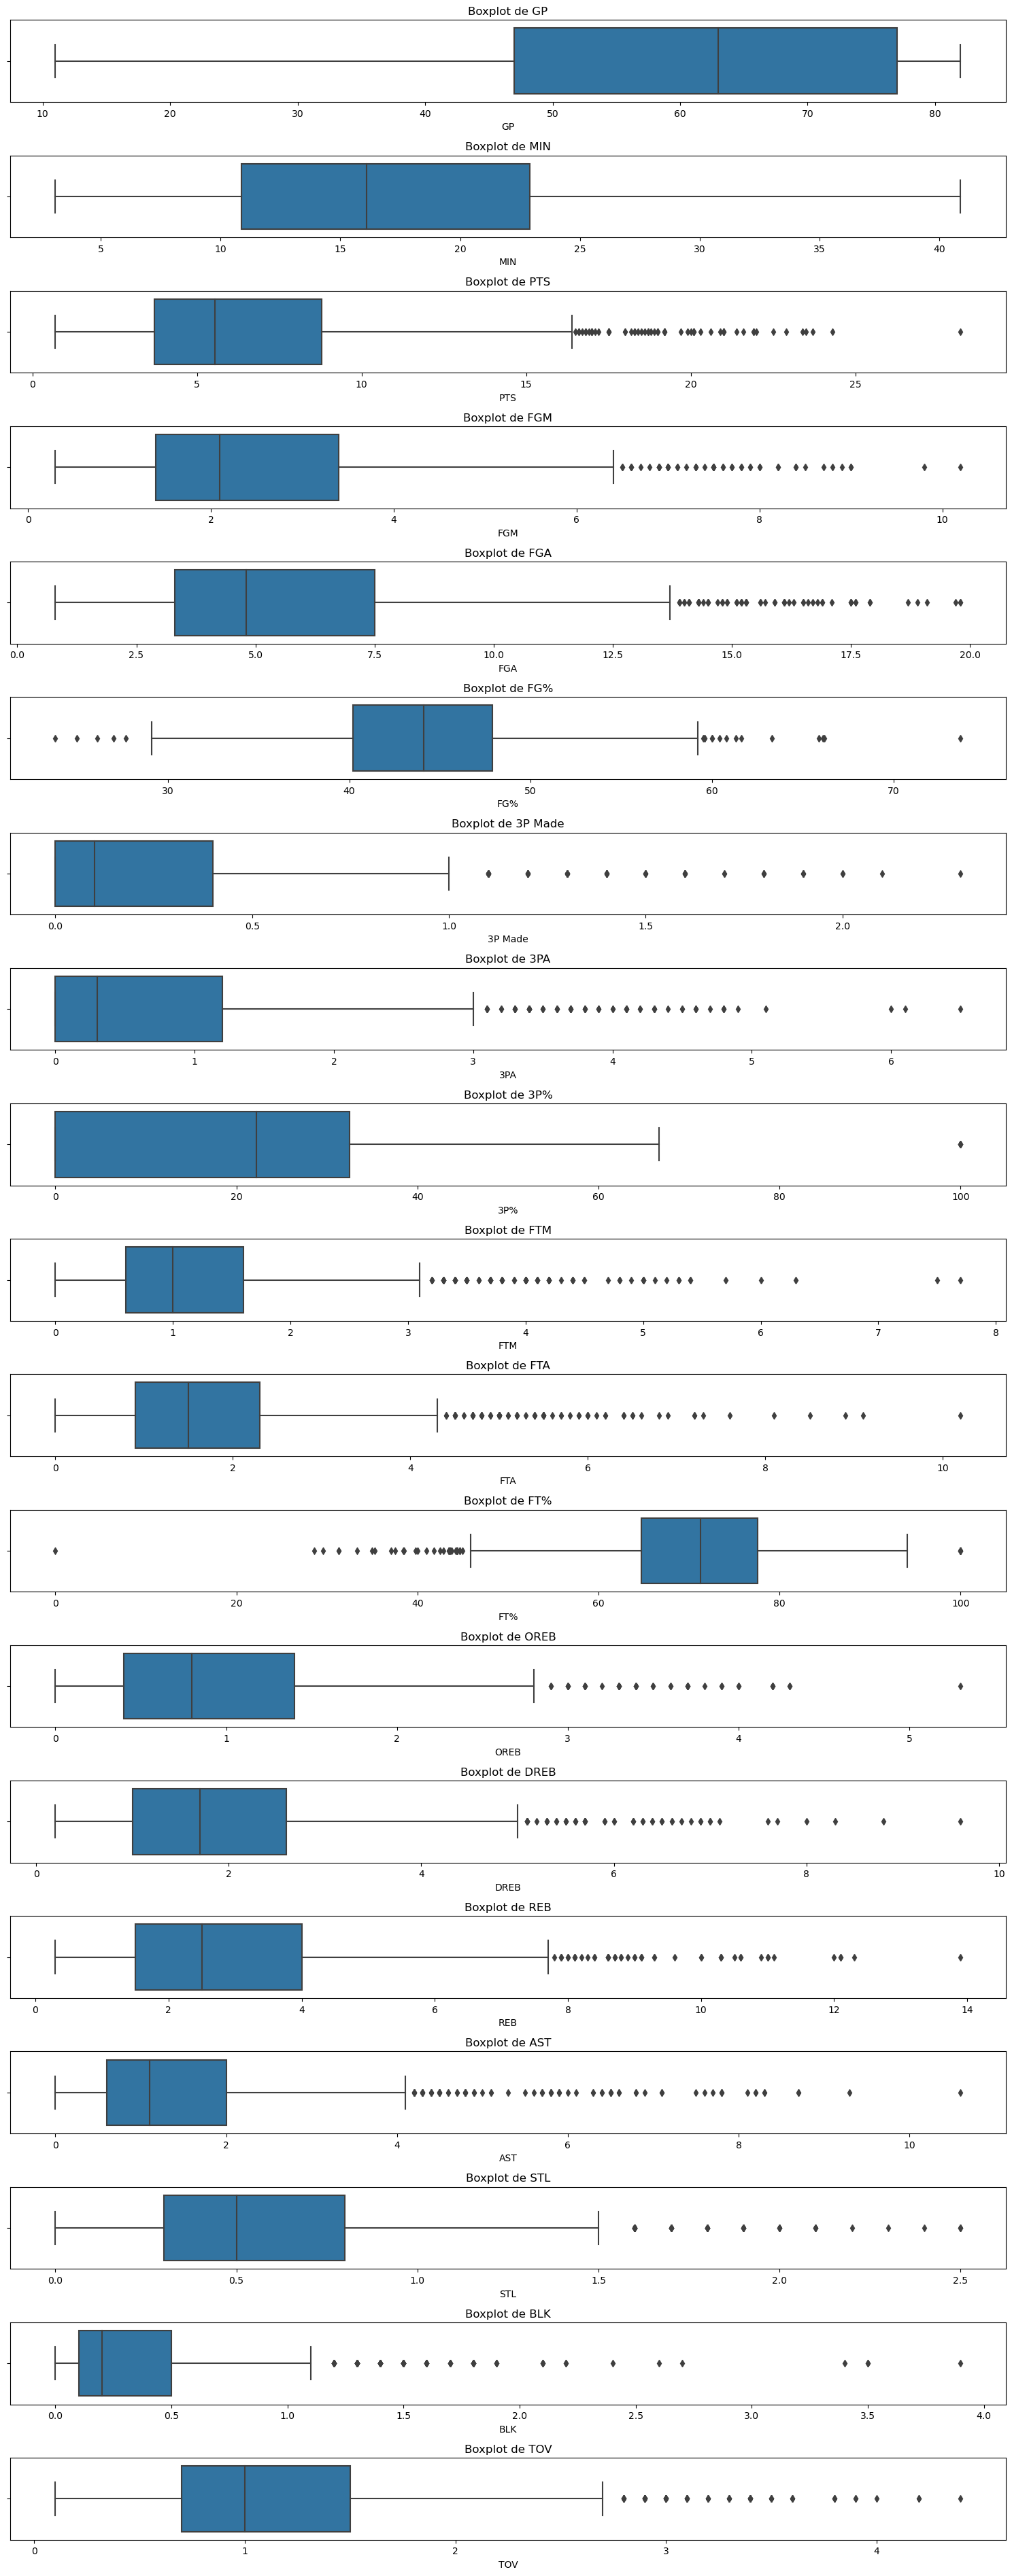

In [13]:


# Graphiques en bougie pour chaque variable
plt.figure(figsize=(15, len(numeric_cols) * 2))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


### Boxplot : on voit une distribution asymétrique avec des outliers (superstars)


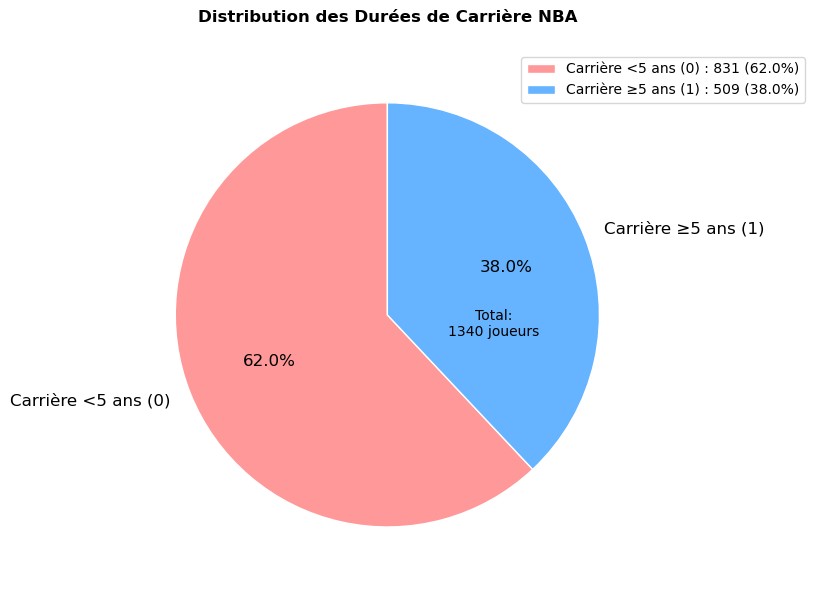

In [92]:
# Distribution de la variable cible TARGET_5Yrs (camembert + comptage)
target_counts = df['TARGET_5Yrs'].value_counts()
labels = ['Carrière <5 ans (0)', 'Carrière ≥5 ans (1)']
colors = ['#ff9999', '#66b3ff']  # Rouge pour <5 ans, Bleu pour ≥5 ans

plt.figure(figsize=(8, 6))
plt.pie(
    target_counts, 
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12}
)

# Ajout du titre et annotation du nombre absolu
plt.title('Distribution des Durées de Carrière NBA', pad=20, fontweight='bold')
plt.annotate(
    f"Total:\n{target_counts.sum()} joueurs", 
    xy=(0.5, -0.1), 
    ha='center',
    fontsize=10
)

# Affichage des valeurs absolues dans le pie
plt.legend(
    [f"{label} : {count} ({pct:.1f}%)" for label, count, pct in zip(
        labels, 
        target_counts, 
        target_counts/target_counts.sum()*100
    )],
    loc="upper right",
    bbox_to_anchor=(1.3, 1)
)

plt.tight_layout()
plt.show()

### On voit qu'on a une répartition inégale avec près de deux tiers en carrière longue

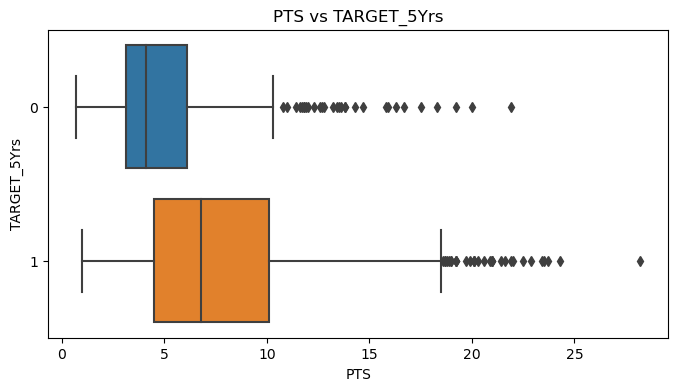

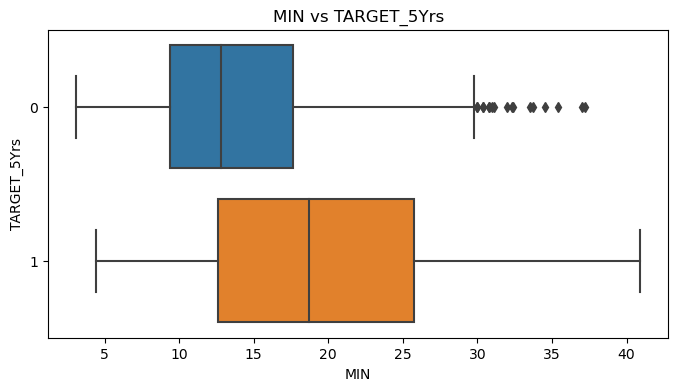

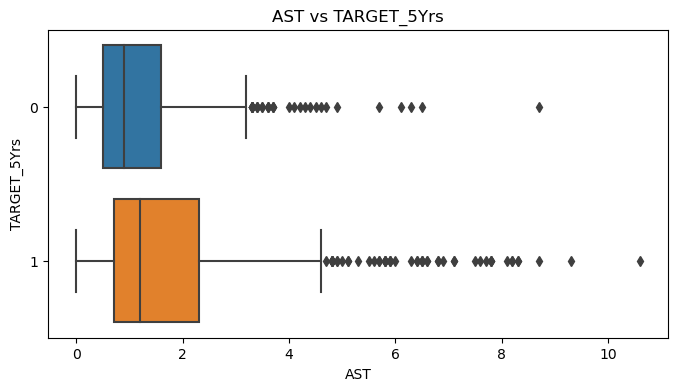

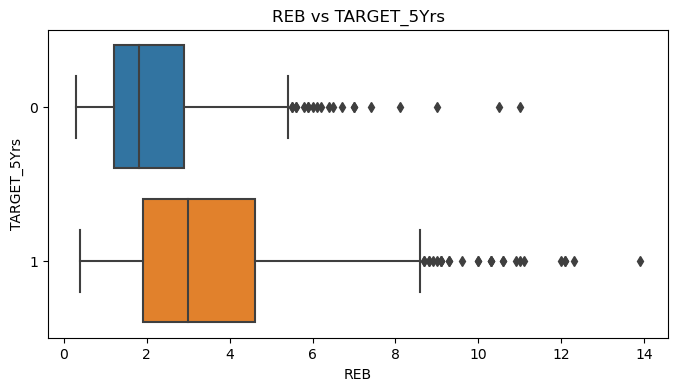

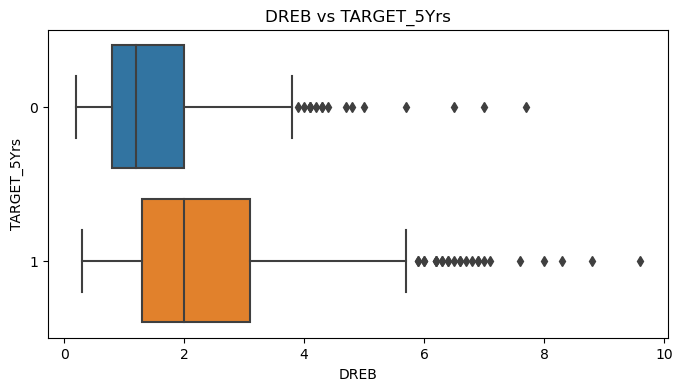

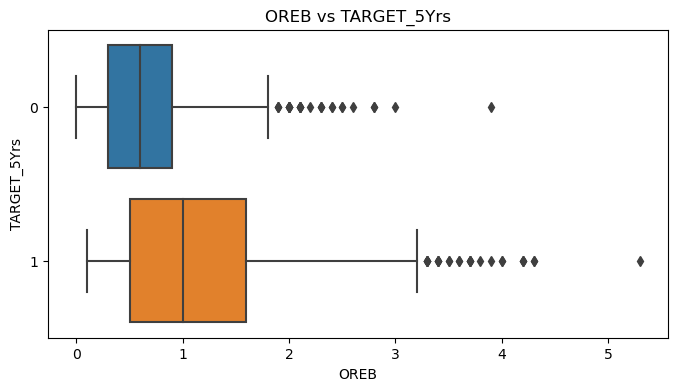

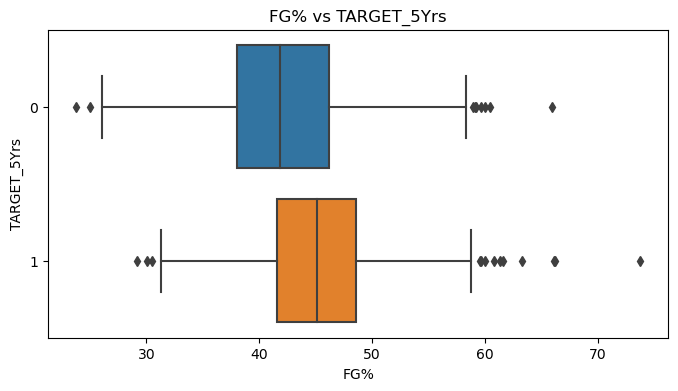

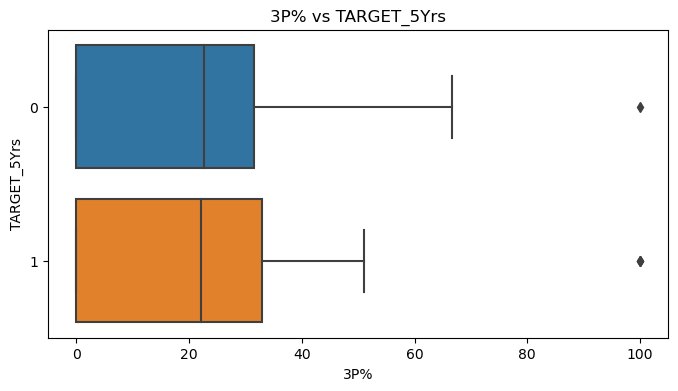

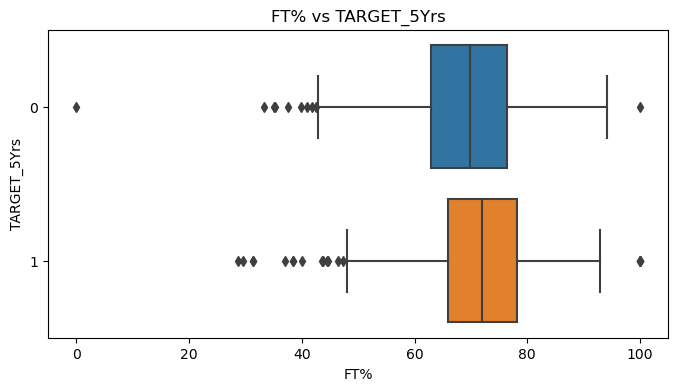

In [15]:
# Visualisation des relations features vs cible (boxplots horizontaux)
features_to_plot = ['PTS', 'MIN', 'AST', 'REB','DREB','OREB', 'FG%', '3P%', 'FT%']  # à adapter selon ton dataset

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.boxplot(y='TARGET_5Yrs', x=feature, data=df, orient='h')
    plt.title(f'{feature} vs TARGET_5Yrs')
    plt.show()


### dans l'ensemble, on voit que les joueurs peu importe leur longévité ont a peu près le même range de performance, il y a des données non dispoonibles qui peuvent l'expliquer : blessures, situation personnelles, age, poste, etc ...

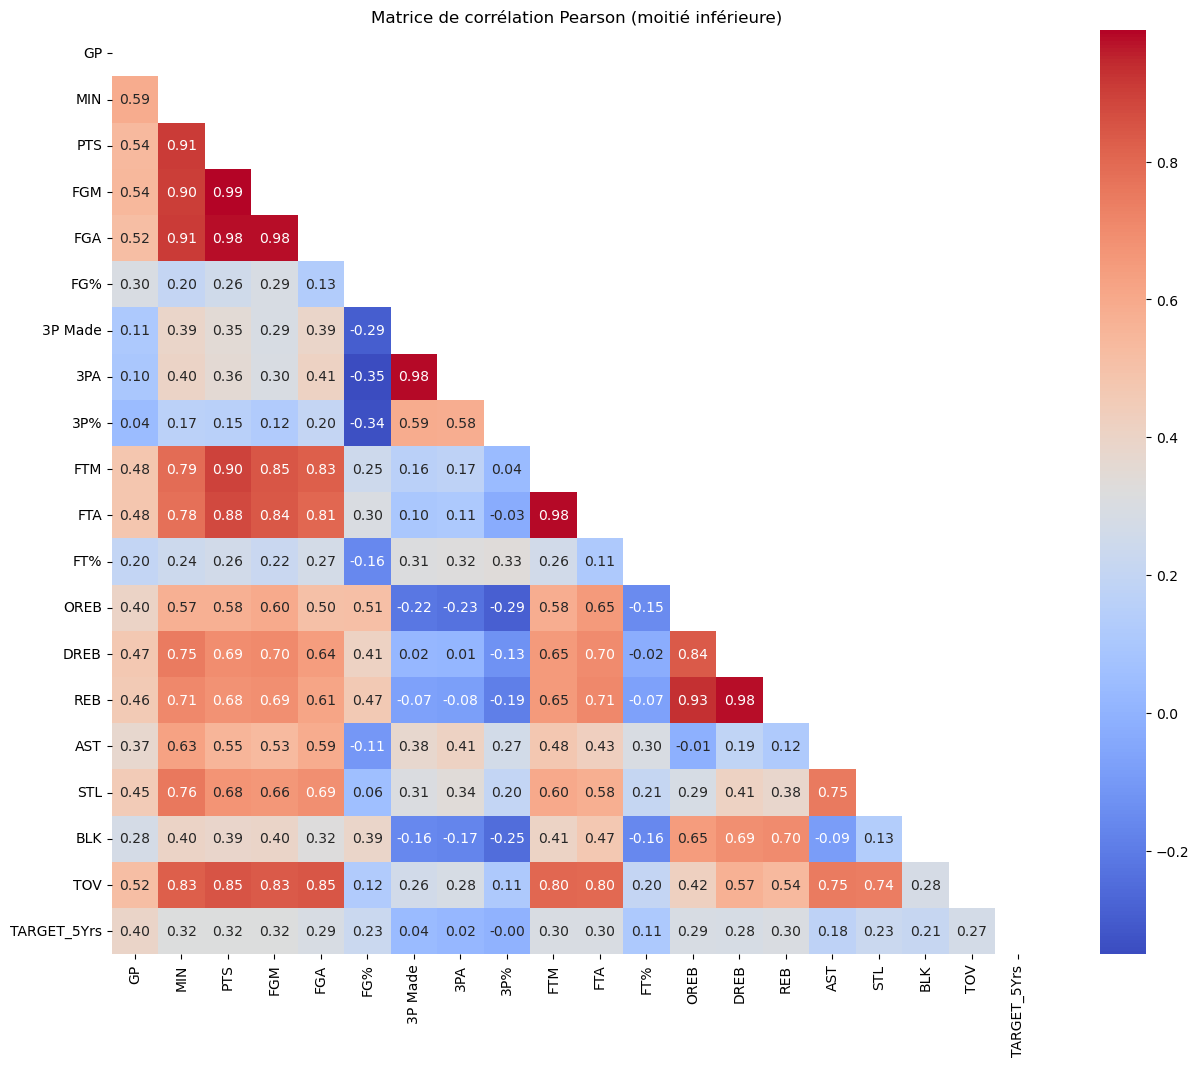

In [16]:
# calcul de la matrice de corrélation (Pearson par défaut)
corr_matrix_pearson = df.corr()


plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(corr_matrix_pearson, dtype=bool))  # masque la moitié supérieure
sns.heatmap(corr_matrix_pearson, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation Pearson (moitié inférieure)')
plt.show()


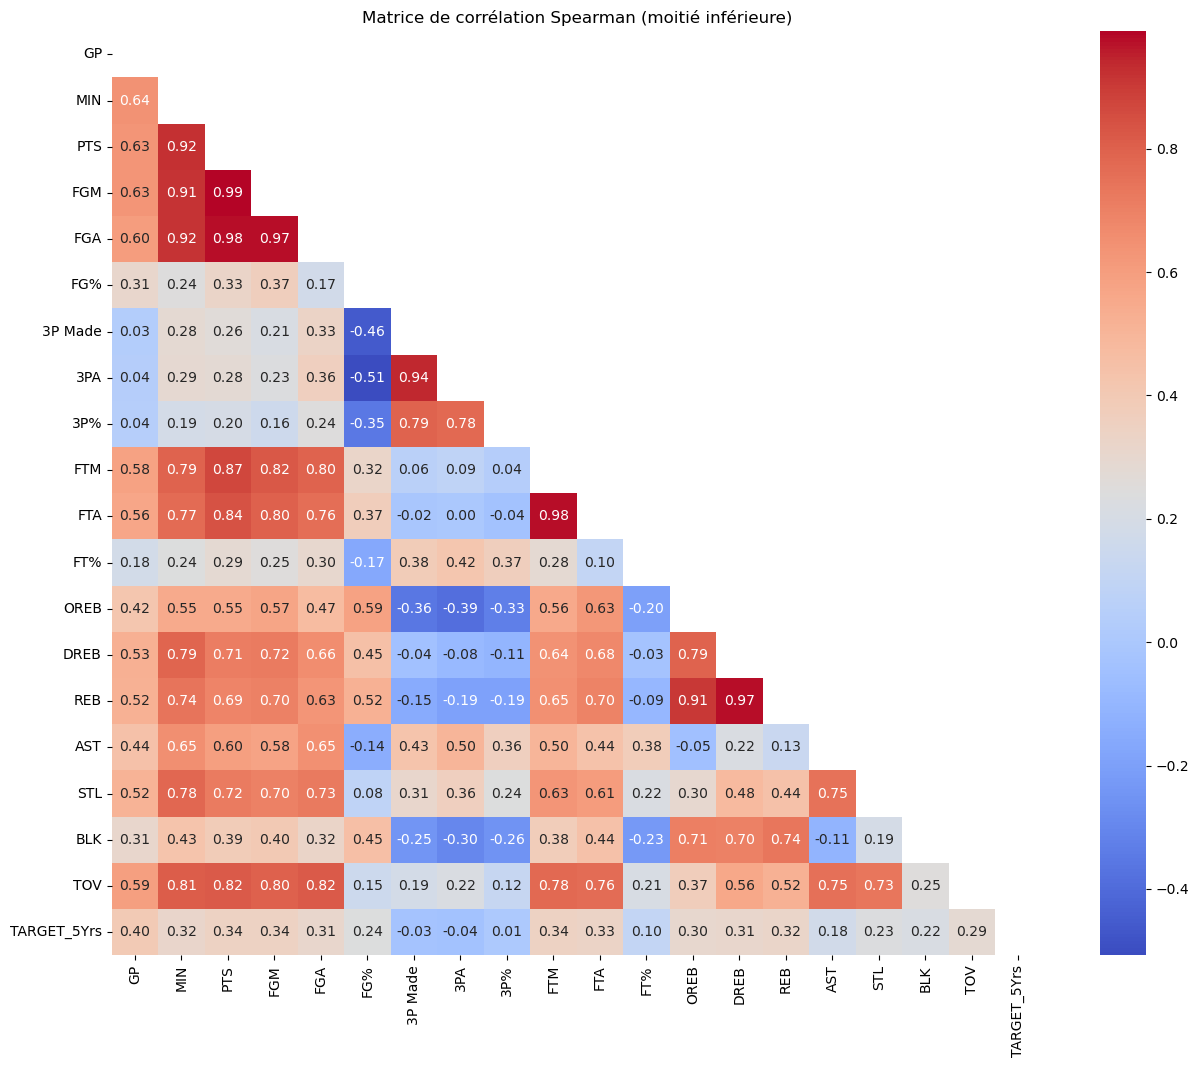

In [17]:
# calcul de la matrice de corrélation Spearman (inclut la target)
corr_matrix_spearman = df.corr(method='spearman')

# affichage avec heatmap
plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype=bool))  # masque moitié supérieure
sns.heatmap(corr_matrix_spearman, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation Spearman (moitié inférieure)')
plt.show()

In [18]:
# seuil de corrélation pour considérer une redondance
seuil = 0.90

def get_high_corr_pairs(corr_matrix, seuil=0.85):
    corr_matrix_abs = corr_matrix.abs()
    # Masque la diagonale et la moitié supérieure
    mask = np.triu(np.ones_like(corr_matrix_abs, dtype=bool))
    corr_matrix_masked = corr_matrix_abs.mask(mask)
    
    # Trouver toutes les paires supérieures au seuil
    high_corr = corr_matrix_masked.stack()
    high_corr = high_corr[high_corr > seuil].sort_values(ascending=False)
    return high_corr

# Spearman
high_corr_spearman = get_high_corr_pairs(corr_matrix_spearman, seuil)
print("Paires de features fortement corrélées (Spearman) :")
print(high_corr_spearman)

# Pearson
high_corr_pearson = get_high_corr_pairs(corr_matrix_pearson, seuil)
print("\nPaires de features fortement corrélées (Pearson) :")
print(high_corr_pearson)


Paires de features fortement corrélées (Spearman) :
FGM  PTS        0.990493
FGA  PTS        0.975944
FTA  FTM        0.975564
FGA  FGM        0.974310
REB  DREB       0.973636
3PA  3P Made    0.939316
PTS  MIN        0.924537
FGA  MIN        0.916515
FGM  MIN        0.914580
REB  OREB       0.905563
dtype: float64

Paires de features fortement corrélées (Pearson) :
FGM  PTS        0.990834
3PA  3P Made    0.982616
FTA  FTM        0.980505
FGA  FGM        0.980050
     PTS        0.979733
REB  DREB       0.978177
     OREB       0.932694
PTS  MIN        0.911822
FGA  MIN        0.910247
FGM  MIN        0.903060
dtype: float64


In [19]:
corr_matrix_spearman["TARGET_5Yrs"]

GP             0.396913
MIN            0.317360
PTS            0.344736
FGM            0.344800
FGA            0.307072
FG%            0.239037
3P Made       -0.031888
3PA           -0.038425
3P%            0.006878
FTM            0.341028
FTA            0.330763
FT%            0.102149
OREB           0.304435
DREB           0.306155
REB            0.320500
AST            0.176212
STL            0.232763
BLK            0.217504
TOV            0.285391
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

In [20]:
corr_matrix_pearson["TARGET_5Yrs"]

GP             0.396833
MIN            0.317805
PTS            0.315981
FGM            0.317594
FGA            0.292660
FG%            0.227134
3P Made        0.036619
3PA            0.018110
3P%           -0.000004
FTM            0.296841
FTA            0.296089
FT%            0.106706
OREB           0.293307
DREB           0.284677
REB            0.299406
AST            0.175353
STL            0.229811
BLK            0.210114
TOV            0.272348
TARGET_5Yrs    1.000000
Name: TARGET_5Yrs, dtype: float64

# Analyse des corrélations et sélection de features

## 1️⃣ Analyse des corrélations avec la target

### Variables modérément corrélées (0.3–0.4)
- **Features informatives** :  
  `GP`, `PTS`, `FGM`, `FGA`, `FTM`, `FTA`, `MIN`, `REB`  
  → *Ces variables expliquent le mieux la target*.

### Variables faiblement corrélées (<0.2)
- **Peu contributives** :  
  `AST`, `STL`, `BLK`, `FT%`  
  → *Impact limité sur la target*.

### Variables non corrélées/négatives
- **Sans impact direct** :  
  `3PA`, `3P Made`, `3P%`  
  → *Peu utiles pour prédire la target*.

---

## 2️⃣ Analyse des paires fortement corrélées

### Groupes redondants
| Variables              | Action recommandée                          |
|------------------------|--------------------------------------------|
| `FGM`, `FGA`, `PTS`, `MIN` | Garder **`PTS`** ou **`MIN + PTS`**       |
| `FTA`, `FTM`           | Combiner en **`FT_impact = FTM * FT%`**    |
| `REB`, `DREB`, `OREB`  | Garder **`REB`** + ratio **`OREB/REB`**    |
| `3PA`, `3P Made`       | Garder **`3P%`** (efficacité) ou **`3P Made`** (volume) |

---

## 3️⃣ Proposition de features finales

| Feature originale | Action / Transformation               | Raison                                                                 |
|-------------------|---------------------------------------|-----------------------------------------------------------------------|
| **`PTS`**         | Garder                                | Corrélation forte avec la target (scoring total)                      |
| **`MIN`**         | Optionnelle                           | Utile pour normaliser l'efficacité                                    |
| **`FGM`**, `FGA`  | Supprimer ou combiner                 | Redondantes avec `PTS`                                                |
| **`FTM`**, `FTA`  | Créer **`FT_impact = FTM * FT%`**     | Combine volume et efficacité                                          |
| **`3P`**-related  | Créer **`3P_impact = 3P Made * 3P%`** | Capture à la fois le volume et la précision                           |
| **`REB`**         | Garder + ratio **`OREB/REB`**         | Réduit la multicolinéarité et conserve l'info offensive               |
| **`AST`**, `STL`, `BLK`, `TOV` | Garder si pertinent           | Peu corrélées à la target, mais potentiellement utiles pour certains modèles |

### Notes supplémentaires
- **`FT%`** : Devenue optionnelle si intégrée dans `FT_impact`.
- **Modèles complexes** (Random Forest, SVM) : Les features faiblement corrélées (`AST`, `STL`) peuvent apporter un signal complémentaire.

# Plan de sélection et transformation des features

## 1️⃣ Colonnes à conserver sans modification

| Feature | Justification |
|---------|---------------|
| **`PTS`** | Capture le scoring total (forte corrélation avec la target) |
| **`REB`** | Synthétise les rebonds totaux (remplace `DREB` + `OREB`) |
| **`AST`** | Signal complémentaire malgré faible corrélation (passe décisive) |
| **`STL`** | Information défensive (interceptions) |
| **`BLK`** | Information défensive (contres) |
| **`TOV`** | Indicateur d'efficacité globale (pertes de balle) |
| **`MIN`** | *(Optionnel)* Permet de normaliser d'autres stats par minute |

## 2️⃣ Colonnes à supprimer (redondances)

- `FGM`, `FGA` → Déjà encapsulées dans **`PTS`**
- `DREB`, `OREB` → Remplacées par **`REB`**
- `FTA` → Redondante avec `FTM`
- `3PA` → Redondante avec `3P Made` ou `3P%`

## 3️⃣ Colonnes à transformer/combiner

### Transformations proposées

| Features d'origine | Nouvelle feature | Formule | Avantage |
|--------------------|------------------|---------|----------|
| `FTM` + `FT%` | **`FT_impact`** | `FTM * FT%` | Combine volume et efficacité au lancer-franc |
| `3P Made` + `3P%` | **`3P_impact`** | `3P Made * 3P%` | Mesure combinée de volume et précision à 3-points |

💡 **Option** :  
- Conserver uniquement **`3P%`** pour l'efficacité pure  
- Ou **`3P Made`** pour le volume seul  
- *(Recommandé : `3P_impact` pour une vision synthétique)*

---


In [21]:

# --- Création des colonnes combinées ---
# Free Throw impact : volume * efficacité
#df['FT_impact'] = df['FTM'] * df['FT%']

# 3-Point impact : volume * efficacité
#df['3P_impact'] = df['3P Made'] * df['3P%']

# --- Colonnes à drop ---
#cols_to_drop = ['FGM', 'FGA', 'DREB', 'OREB', 'FTA', '3PA', 'FTM', '3P Made', '3P%']

#df_clean = df.drop(columns=cols_to_drop)


In [22]:
# --- Colonnes combinées déjà créées ---
# Free Throw impact : volume * efficacité
df['FT_impact'] = df['FTM'] * df['FT%']

# 3-Point impact : volume * efficacité
df['3P_impact'] = df['3P Made'] * df['3P%']

# --- Colonnes totales ---
#df['Minutes_totales'] = df['GP'] * df['MIN']
#df['Points_totales'] = df['PTS'] * df['GP']

# --- Ratios par minute ---
#df['Points_per_min'] = df['PTS'] / df['MIN']
#df['3P_per_min'] = df['3P Made'] / df['MIN']
#df['Rebounds_per_min'] = df['REB'] / df['MIN']
#df['Assists_per_min'] = df['AST'] / df['MIN']
#df['Steals_per_min'] = df['STL'] / df['MIN']
#df['Blocks_per_min'] = df['BLK'] / df['MIN']
#df['Turnovers_per_min'] = df['TOV'] / df['MIN']

# --- Ratios d'efficacité ---
#df['Shooting_efficiency'] = df['FGM'] / df['FGA']

# --- Colonnes à drop ---
cols_to_drop = [
    'FGM', 'FGA', 'DREB', 'OREB', 'FTA', '3PA', 'FTM', '3P Made', '3P%'
]

df_clean = df.drop(columns=cols_to_drop)



#### En ayant fait plusieurs essais de features engineering, plus les colonnes étaient nombreuses et moins parfois les modèles avait de bons scores, j'ai donc pris en compte cela et adapté le nombre de colonne avec le nombre de lignes de manière a ce que ce soit cohérent pour les modèles et éviter les overfitting ou underfitting

In [23]:
df_clean.head()

,Name,GP,MIN,PTS,FG%,FT%,REB,AST,STL,BLK,TOV,TARGET_5Yrs,FT_impact,3P_impact
0,Brandon Ingram,36,27.4,7.4,34.7,69.9,4.1,1.9,0.4,0.4,1.3,0,111.84,12.50
1,Andrew Harrison,35,26.9,7.2,29.6,76.5,2.4,3.7,1.1,0.5,1.6,0,198.90,16.45
2,JaKarr Sampson,74,15.3,5.2,42.2,67.0,2.2,1.0,0.5,0.3,1.0,0,60.30,9.76
3,Malik Sealy,58,11.6,5.7,42.6,68.9,1.9,0.8,0.6,0.1,1.0,1,62.01,2.26
4,Matt Geiger,48,11.5,4.5,52.4,67.4,2.5,0.3,0.3,0.4,0.8,1,87.62,0.00


In [24]:
print(df_clean.isna().sum())  # Si c'est un DataFrame

# Sélection des colonnes numériques uniquement
num_cols = df_clean.select_dtypes(include=np.number).columns

# Vérification des infinis
print(np.isinf(df_clean[num_cols]).sum())


Name           0
GP             0
MIN            0
PTS            0
FG%            0
FT%            0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
FT_impact      0
3P_impact      0
dtype: int64
GP             0
MIN            0
PTS            0
FG%            0
FT%            0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
FT_impact      0
3P_impact      0
dtype: int64


In [25]:
# On vérifie les types pcq les float 64 ca passe mais 128 bits peut faire faire bugger les modèles
pd.DataFrame(df_clean.dtypes, columns=['Type'])


,Type
Name,object
GP,int64
MIN,float64
PTS,float64
FG%,float64
FT%,float64
REB,float64
AST,float64
STL,float64
BLK,float64


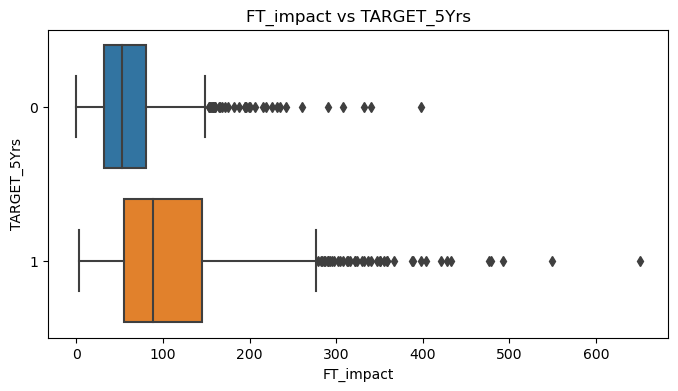

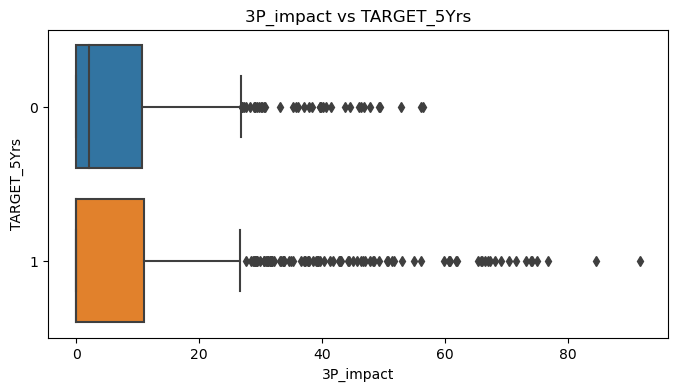

In [26]:
# Visualisation des relations features vs cible (boxplots horizontaux)
features_to_plot = ['FT_impact', '3P_impact']  # à adapter selon ton dataset

for feature in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.boxplot(y='TARGET_5Yrs', x=feature, data=df_clean, orient='h')
    plt.title(f'{feature} vs TARGET_5Yrs')
    plt.show()


#### On peut voir que pour les carrieres longues, la médiane est confondue avec le quantile : les colonnes produites qui montrent l'impact direct montre ici une difference même si on voit bcp d'individus performants avec des carrieres courtes 

In [29]:

def prepare_scaled_data(df, target_col, cols_to_scale, test_size=0.2, random_state=42):
    """
    Sépare le dataset en train/test et standardise les colonnes numériques spécifiées.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataset complet.
    target_col : str
        Nom de la colonne cible.
    cols_to_scale : list
        Liste des colonnes à standardiser.
    test_size : float, default=0.2
        Proportion du test set.
    random_state : int, default=42
        Pour reproductibilité.
    
    Returns
    -------
    X_train_scaled : pd.DataFrame
        Features standardisées pour l'entraînement.
    X_test_scaled : pd.DataFrame
        Features standardisées pour le test.
    y_train : pd.Series
        Labels d'entraînement.
    y_test : pd.Series
        Labels de test.
    scaler : StandardScaler
        Objet scaler (utile si besoin de transformer de nouvelles données).
    """
    
    # Séparation des features et labels
    X = df[cols_to_scale]
    y = df[target_col]
    
    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=cols_to_scale,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=cols_to_scale,
        index=X_test.index
    )
    
    print("Dataset prêt pour l'entraînement :")
    print("X_train shape:", X_train_scaled.shape)
    print("X_test shape:", X_test_scaled.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


In [96]:
#on selectionne les colonnes numériques pour scaler : centre et réduit 
# en gros on soustrait la moyenne puis on divise par ecart type
# cela permet de baisser les dimensions pour les calculs linéaire comme la régression 


cols_standard = df_clean.select_dtypes(include='number').columns.drop('TARGET_5Yrs')
print(cols_standard)

Index(['GP', 'MIN', 'PTS', 'FG%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'FT_impact', '3P_impact'],
      dtype='object')


In [31]:

X_train_scaled, X_test_scaled, y_train, y_test, scaler_std = prepare_scaled_data(
    df_clean, target_col='TARGET_5Yrs', cols_to_scale=cols_standard
)


Dataset prêt pour l'entraînement :
X_train shape: (1072, 12)
X_test shape: (268, 12)
y_train shape: (1072,)
y_test shape: (268,)


In [97]:
X_test_scaled.describe()
# on devrait voir des moyenne = 0 et des ecart type std = 1 (environ)

,GP,MIN,PTS,FG%,FT%,REB,AST,STL,BLK,TOV,FT_impact,3P_impact
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000
mean,0.071132,0.061353,0.049239,0.022154,-0.036889,0.099036,-0.037749,0.018595,0.031836,0.016927,0.017289,0.025246
std,0.976713,1.038789,1.031812,0.939368,0.986481,1.079254,0.985389,0.980036,1.014149,1.004219,1.094115,1.007876
min,-2.751128,-1.616778,-1.353429,-2.421940,-3.307501,-1.232876,-0.990773,-1.256716,-0.855207,-1.511448,-1.117413,-0.588075
25%,-0.652016,-0.806781,-0.706614,-0.602492,-0.617923,-0.689194,-0.651852,-0.770538,-0.621453,-0.680326,-0.684189,-0.588075
50%,0.276163,-0.118133,-0.244603,0.001307,0.091597,-0.194936,-0.346824,-0.162815,-0.387700,-0.264765,-0.277143,-0.588075
75%,0.961587,0.782874,0.523490,0.737942,0.704472,0.558806,0.093772,0.444908,0.313561,0.427837,0.305309,0.304082
max,1.247180,2.836685,4.953019,2.682175,2.066939,4.500506,5.245360,4.334334,7.092419,3.890845,7.439552,4.721708


# Randomized Search

In [35]:

# Paramètres des modèles (pour RandomizedSearchCV, on peut utiliser des distributions)
#models_params = {
#    'RandomForest': {
#        'model': RandomForestClassifier(random_state=42),
#       'params': {
#            'n_estimators': randint(50, 201),
#            'max_depth': [None, 5, 10, 15],
#            'min_samples_split': randint(2, 11)
#        }
#    },
#    'XGBoost': {
 #       'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
  #      'params': {
#            'n_estimators': randint(50, 201),
#            'max_depth': randint(3, 8),
#            'learning_rate': uniform(0.01, 0.19)  # de 0.01 à 0.2
#        }
#    },
#    'SVM': {
#        'model': SVC(probability=True, random_state=42),
#        'params': {
#            'C': uniform(0.1, 9.9),  # de 0.1 à 10
#            'kernel': ['linear', 'rbf'],
#            'gamma': ['scale', 'auto']
#        }
#    },
#    'LogisticRegression': {
#        'model': LogisticRegression(max_iter=1000, random_state=42),
#        'params': {
#            'C': uniform(0.1, 9.9),
#            'penalty': ['l2'],
#            'solver': ['lbfgs']
#        }
#    }
#}
#
#model_scores = {}

# CV et scorer
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#scorer = make_scorer(recall_score)

#best_models = {}

# Boucle sur les modèles
#for name, mp in models_params.items():
#    print(f"\n🔍 RandomizedSearchCV pour {name}...")

#    random_search = RandomizedSearchCV(
#        mp['model'],
   #     mp['params'],
#        scoring=scorer,
#        cv=kf,
 #       n_iter=30,       # nombre de combinaisons aléatoires à tester
# #       n_jobs=-1,
 #       random_state=42
  #  )
    
 #   random_search.fit(X_train, y_train)
    
 #   best_models[name+"_recall_score_rs"] = random_search.best_estimator_
    
 #   # Prédictions en CV sur train (pas de fuite)
 #   cv_preds = cross_val_predict(random_search.best_estimator_, X_train, y_train, cv=kf)
 #   
 #   recall = recall_score(y_train, cv_preds)
 #   precision = precision_score(y_train, cv_preds)
 #   accuracy = accuracy_score(y_train, cv_preds)
    
  #  model_scores[name+"_recall_score"] = {'recall': recall, 'precision': precision}
    
  #  print(f"Meilleur recall (CV) : {random_search.best_score_:.4f}")
  #  print(f"Meilleurs paramètres : {random_search.best_params_}")
  #  print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
  #  print("Confusion Matrix:")
  #  print(confusion_matrix(y_train, cv_preds))


In [36]:
# on stockera de manière brouillone les metrics et param 
#dans ce dictionnaire 
# Les fonctions sont maj pour stocker à présent sur MLFLOW , les infos des models
all_scoring_models = {}

In [98]:
#on utilise le randomized qui va choisir aleatoirement les parametre sur des
# modeles avec bcp de parametre et de combinaisons pour mieux choisir les
# params sur le gridsearch 

# le gridsearch fait tout les parametres proposer dans la grille mais 
#c'est long

# alors le grid search randomise les parametre et itere ce qui permet 
# de reduire le temps et de determiner a peu pres les parametre a tester 
# en gridsearch par la suite 
def run_randomized_search(models_params, X_train, y_train, scorer_name='precision', cv_folds=5, n_iter=20):
    """
    Exécute un RandomizedSearchCV sur plusieurs modèles avec CV et retourne les meilleurs modèles et scores.
    
    Parameters
    ----------
    models_params : dict
        Dictionnaire contenant les modèles et leur param_grid.
    X_train : array-like
        Données d'entraînement.
    y_train : array-like
        Labels d'entraînement.
    scorer_name : str, default='precision'
        Choix du scorer ('precision', 'recall', 'accuracy').
    cv_folds : int, default=5
        Nombre de folds pour la cross-validation.
    n_iter : int, default=20
        Nombre d'itérations aléatoires à tester dans RandomizedSearchCV.
    
    Returns
    -------
    best_models : dict
        Modèles optimisés par RandomizedSearchCV.
    model_scores : dict
        Scores (recall, precision, accuracy) obtenus en CV sur train.
    """
    
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score)
    }
    
    if scorer_name not in scorers:
        raise ValueError(f"scorer_name doit être dans {list(scorers.keys())}")
    
    scorer = scorers[scorer_name]
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    best_models = {}
    model_scores = {}
    
    for name, mp in models_params.items():
        print(f"\n 🔍 RandomizedSearchCV pour {name}...")
        
        rand_search = RandomizedSearchCV(
            mp['model'],
            mp['params'],
            scoring=scorer,
            cv=kf,
            n_iter=n_iter,
            n_jobs=-1,
            random_state=42
        )
        rand_search.fit(X_train, y_train)
        
        
        # Prédictions en CV sur train
        cv_preds = cross_val_predict(rand_search.best_estimator_, X_train, y_train, cv=kf)
        
        recall = recall_score(y_train, cv_preds)
        precision = precision_score(y_train, cv_preds)
        accuracy = accuracy_score(y_train, cv_preds)
        
        model_scores[name+"_best_"+scorer_name+"_rs"] = {'recall': recall, 'precision': precision, 'accuracy': accuracy , 'params':rand_search.best_estimator_.get_params()  ,'trained_estimator': rand_search.best_estimator_.__class__.__name__ }
        

        with mlflow.start_run(run_name=name+"_best_"+scorer_name+f"rs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
            # log hyperparams
            mlflow.log_params(rand_search.best_params_)
            # log metrics
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("accuracy", accuracy)
            # log le nom du modèle
            mlflow.log_param("model", rand_search.best_estimator_.__class__.__name__)
            # log l’artefact
            mlflow.sklearn.log_model(rand_search.best_estimator_, "model")
        
        print(f"Meilleur {scorer_name} (CV) : {rand_search.best_score_:.4f}")
        print(f"Meilleurs paramètres : {rand_search.best_params_}")
        print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
        print(f"=== {name} ===")
        print("Confusion Matrix:")
        print(confusion_matrix(y_train, cv_preds))
    
    return  model_scores


In [41]:

# Paramètres pour RandomizedSearchCV
models_params = {
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': uniform(0.1, 10),          # C entre 0.1 et 10
            'kernel': ['linear', 'rbf'],    # Linear et RBF
            'gamma': ['scale', 'auto']      # Gamma
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': randint(50, 150),       # Nb d'arbres entre 50 et 150
            'max_depth': randint(3, 10),            # Profondeur entre 3 et 10
            'learning_rate': uniform(0.01, 0.2),    # Learning rate entre 0.01 et 0.21
            'subsample': uniform(0.6, 0.4),         # Sous-échantillonnage entre 0.6 et 1.0
            'colsample_bytree': uniform(0.6, 0.4)   # Fraction de colonnes par arbre
        }
    }
}


In [42]:
n_iter_search = 100  

# Lancement du RandomizedSearch pour SVM et XGBoost
model_scores_random_recall = run_randomized_search(models_params, X_train_scaled, y_train, 
                                                  scorer_name='recall', cv_folds=5, n_iter=n_iter_search)

all_scoring_models = all_scoring_models | model_scores_random_recall

# Lancement du RandomizedSearch pour SVM et XGBoost
model_scores_random_precision = run_randomized_search(models_params, X_train_scaled, y_train, 
                                                  scorer_name='precision', cv_folds=5, n_iter=n_iter_search)

all_scoring_models = all_scoring_models | model_scores_random_precision



 🔍 RandomizedSearchCV pour SVM...


C:\Users\lyesw\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Meilleur recall (CV) : 0.8354
Meilleurs paramètres : {'C': 0.30584494295802445, 'gamma': 'auto', 'kernel': 'rbf'}
Recall (CV) : 0.8353 | Precision (CV) : 0.7276 | Accuracy (CV) : 0.7052
=== SVM ===
Confusion Matrix:
[[203 207]
 [109 553]]

 🔍 RandomizedSearchCV pour XGBoost...
Meilleur recall (CV) : 0.8700
Meilleurs paramètres : {'colsample_bytree': 0.8446612641953124, 'learning_rate': 0.011413261043943482, 'max_depth': 3, 'n_estimators': 98, 'subsample': 0.8099098641033556}
Recall (CV) : 0.8701 | Precision (CV) : 0.7042 | Accuracy (CV) : 0.6940
=== XGBoost ===
Confusion Matrix:
[[168 242]
 [ 86 576]]

 🔍 RandomizedSearchCV pour SVM...
Meilleur precision (CV) : 0.7401
Meilleurs paramètres : {'C': 9.025589984899778, 'gamma': 'scale', 'kernel': 'rbf'}
Recall (CV) : 0.7764 | Precision (CV) : 0.7385 | Accuracy (CV) : 0.6922
=== SVM ===
Confusion Matrix:
[[228 182]
 [148 514]]

 🔍 RandomizedSearchCV pour XGBoost...
Meilleur precision (CV) : 0.7332
Meilleurs paramètres : {'colsample_bytree':

In [43]:
all_scoring_models

{'SVM_best_recall_rs': {'recall': 0.8353474320241692,
  'precision': 0.7276315789473684,
  'accuracy': 0.7052238805970149,
  'params': {'C': 0.30584494295802445,
   'break_ties': False,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 0.0,
   'decision_function_shape': 'ovr',
   'degree': 3,
   'gamma': 'auto',
   'kernel': 'rbf',
   'max_iter': -1,
   'probability': True,
   'random_state': 42,
   'shrinking': True,
   'tol': 0.001,
   'verbose': False},
  'trained_estimator': 'SVC'},
 'XGBoost_best_recall_rs': {'recall': 0.8700906344410876,
  'precision': 0.7041564792176039,
  'accuracy': 0.6940298507462687,
  'params': {'objective': 'binary:logistic',
   'base_score': None,
   'booster': None,
   'callbacks': None,
   'colsample_bylevel': None,
   'colsample_bynode': None,
   'colsample_bytree': 0.8446612641953124,
   'device': None,
   'early_stopping_rounds': None,
   'enable_categorical': False,
   'eval_metric': 'logloss',
   'feature_types': None,
   'gamma': None,
  

In [44]:
# Paramètres des modèles (optimisés pour rapidité + coverage)
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100,  125 , 150, 175 , 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 6]
        }
    },
     'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {
                'C': [0.3, 1, 3, 5, 9],        # autour de tes meilleurs C
                'kernel': ['rbf'],              # tes deux essais étaient rbf
                'gamma': ['scale', 'auto']      # options testées
            }
        },
        'XGBoost': {
            'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
            'params': {
                'n_estimators': [90, 100, 110],          # proche des valeurs testées
                'max_depth': [3, 4, 5],                  # max_depth qui a donné de bons résultats
                'learning_rate': [0.01, 0.02, 0.05],    # petites valeurs testées
                'subsample': [0.7, 0.8, 0.9],           # plage autour de tes essais
                'colsample_bytree': [0.8, 0.85, 0.88]   # plage autour de tes essais
            }
        },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.1, 0.3, 1],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    }
}


In [49]:

def run_grid_search(models_params, X_train, y_train, scorer_name='precision', cv_folds=5):
    """
    Exécute un GridSearchCV sur plusieurs modèles avec CV et retourne les meilleurs modèles et scores.
    
    Parameters
    ----------
    models_params : dict
        Dictionnaire contenant les modèles et leur param_grid.
    X_train : array-like
        Données d'entraînement.
    y_train : array-like
        Labels d'entraînement.
    scorer_name : str, default='precision'
        Choix du scorer ('precision', 'recall', 'accuracy').
    cv_folds : int, default=5
        Nombre de folds pour la cross-validation.
    
    Returns
    -------
    best_models : dict
        Modèles optimisés par GridSearchCV.
    model_scores : dict
        Scores (recall, precision, accuracy) obtenus en CV sur train.
    """
    
    # Choix du scorer
    scorers = {
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'accuracy': make_scorer(accuracy_score)
    }
    
    if scorer_name not in scorers:
        raise ValueError(f"scorer_name doit être dans {list(scorers.keys())}")
    
    scorer = scorers[scorer_name]
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    best_models = {}
    model_scores = {}
    
    for name, mp in models_params.items():
        print(f"\n 🔍 GridSearchCV pour {name}...")
        
        grid = GridSearchCV(mp['model'], mp['params'], scoring=scorer, cv=kf, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        
        # Prédictions en CV sur train
        cv_preds = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=kf)
        
        recall = recall_score(y_train, cv_preds)
        precision = precision_score(y_train, cv_preds)
        accuracy = accuracy_score(y_train, cv_preds)
        
        model_scores[name+"_best_"+scorer_name+"_gs"] = {'recall': recall, 'precision': precision, 'accuracy': accuracy ,'params':grid.best_estimator_.get_params()  , 'trained_estimator': grid.best_estimator_.__class__.__name__ }
        
        with mlflow.start_run(run_name=name+"_best_"+scorer_name+f"gs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):
            # log hyperparams
            mlflow.log_params(grid.best_params_)
            # log metrics
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("accuracy", accuracy)
            # log le nom du modèle
            mlflow.log_param("model", grid.best_estimator_.__class__.__name__)
            # log l’artefact
            mlflow.sklearn.log_model(grid.best_estimator_, "model")
         
        
        
        print(f"Meilleur {scorer_name} (CV) : {grid.best_score_:.4f}")
        print(f"Meilleurs paramètres : {grid.best_params_}")
        print(f"Recall (CV) : {recall:.4f} | Precision (CV) : {precision:.4f} | Accuracy (CV) : {accuracy:.4f}")
        print(f"=== {name} ===")
        print("Confusion Matrix:")
        print(confusion_matrix(y_train, cv_preds))
    
    return  model_scores


# Recherche meilleur Recall

In [50]:
model_scores_grid_recall = run_grid_search(models_params, X_train_scaled, y_train, scorer_name='recall', cv_folds=5)
all_scoring_models = all_scoring_models | model_scores_grid_recall



 🔍 GridSearchCV pour RandomForest...
Meilleur recall (CV) : 0.8150
Meilleurs paramètres : {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Recall (CV) : 0.8157 | Precision (CV) : 0.7287 | Accuracy (CV) : 0.6987
=== RandomForest ===
Confusion Matrix:
[[209 201]
 [122 540]]

 🔍 GridSearchCV pour SVM...
Meilleur recall (CV) : 0.8354
Meilleurs paramètres : {'C': 0.3, 'gamma': 'scale', 'kernel': 'rbf'}
Recall (CV) : 0.8353 | Precision (CV) : 0.7276 | Accuracy (CV) : 0.7052
=== SVM ===
Confusion Matrix:
[[203 207]
 [109 553]]

 🔍 GridSearchCV pour XGBoost...
Meilleur recall (CV) : 0.8990
Meilleurs paramètres : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.7}
Recall (CV) : 0.8988 | Precision (CV) : 0.6935 | Accuracy (CV) : 0.6922
=== XGBoost ===
Confusion Matrix:
[[147 263]
 [ 67 595]]

 🔍 GridSearchCV pour LogisticRegression...
Meilleur recall (CV) : 0.8206
Meilleurs paramètres : {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'

## 📌 Pourquoi la précision est importante pour notre projet NBA

On veut prédire quels joueurs vont rester **≥5 ans en NBA**.  

### 🔹 Matrice de confusion
|                | **Prédit Négatif** | **Prédit Positif** |
|----------------|---------------|---------------|
| **Réel Négatif**  | TN = Évite un mauvais investissement |  FP =  Mauvais investissement|
| **Réel Positif**  | FN = Passe à côté d’un bon joueur ⚠️ | TP = Jackpot  |

#### Recall (rappel) = TP / (TP + FN)  
  → Parmi tous les bons joueurs, combien on a détecté. C’est la proportion de vrais talents qu’on réussit à détecter parmi tous les vrais talents.  
- **Objectif** : ne rater aucun joueur prometteur, quitte à recruter beaucoup de joueurs qui ne valent rien.  
- **Exemple** : PSG, qui vise toujours à avoir toutes les stars possibles et accepte de « perdre de l’argent » sur certains flops.

  ⚠️ Peut être trompeur si le modèle prédit "bon" pour tout le monde (SVM dans notre cas).

#### Precision (précision) = TP / (TP + FP)  
  → Parmi les joueurs prédits bons, combien le sont vraiment. C’est la proportion de bons choix parmi tous les joueurs qu’on recrute.  
- **Objectif** : recruter uniquement des joueurs qui valent vraiment le coup, quitte à passer à côté de certains talents.  
- **Exemple** : Lille, un club plus prudent qui ne veut pas gaspiller son budget mais peut manquer certaines pépites.
  ✅ Plus important ici : éviter de signer des mauvais joueurs et perdre de l’argent.



#### Accuracy (exactitude) = (TP + TN) / total  
  → Donne une idée générale, mais peut être biaisée si les classes sont déséquilibrées.
  

### 🔹 Conclusion
- Pour investir intelligemment : **visez la précision élevée**.  
- Recall reste utile pour savoir si on ne loupe pas trop de talents.


# Recherche meilleur precision

In [51]:
model_scores_grid_precision = run_grid_search(models_params, X_train_scaled, y_train, scorer_name='precision', cv_folds=5)
all_scoring_models = all_scoring_models | model_scores_grid_precision



 🔍 GridSearchCV pour RandomForest...
Meilleur precision (CV) : 0.7327
Meilleurs paramètres : {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
Recall (CV) : 0.8097 | Precision (CV) : 0.7322 | Accuracy (CV) : 0.6996
=== RandomForest ===
Confusion Matrix:
[[214 196]
 [126 536]]

 🔍 GridSearchCV pour SVM...
Meilleur precision (CV) : 0.7397
Meilleurs paramètres : {'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}
Recall (CV) : 0.7749 | Precision (CV) : 0.7381 | Accuracy (CV) : 0.6912
=== SVM ===
Confusion Matrix:
[[228 182]
 [149 513]]

 🔍 GridSearchCV pour XGBoost...
Meilleur precision (CV) : 0.7306
Meilleurs paramètres : {'colsample_bytree': 0.85, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 110, 'subsample': 0.8}
Recall (CV) : 0.8051 | Precision (CV) : 0.7301 | Accuracy (CV) : 0.6959
=== XGBoost ===
Confusion Matrix:
[[213 197]
 [129 533]]

 🔍 GridSearchCV pour LogisticRegression...
Meilleur precision (CV) : 0.7312
Meilleurs paramètres : {'C': 1, 'penalty': 'l2', 'solver'

In [84]:
cols_standards = df.columns.tolist()
cols_standards.remove("TARGET_5Yrs")
cols_standards.remove("Name")
cols_standards

['GP',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3P Made',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'FT_impact',
 '3P_impact']

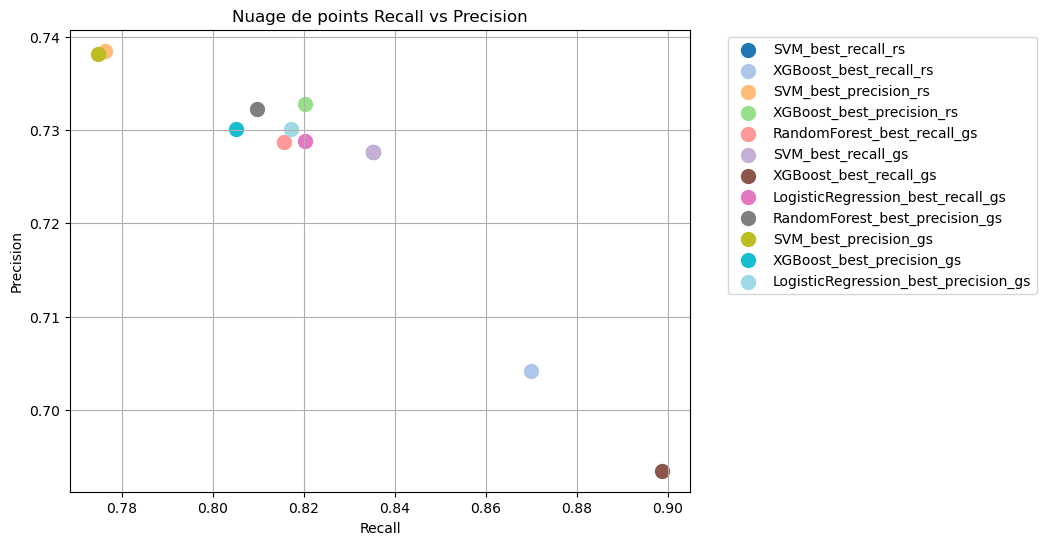

In [53]:
# Ajouter F1-score à chaque entrée
for model, scores in all_scoring_models.items():
    recall = scores['recall']
    precision = scores['precision']
    f1 = 2 * (precision * recall) / (precision + recall)
    all_scoring_models[model]['f1'] = f1

# Créer le nuage de points recall vs precision

plt.figure(figsize=(8,6))
models = list(all_scoring_models.keys())
colors = cm.get_cmap('tab20', len(models))  # 20 couleurs différentes, étendable

for i, model in enumerate(models):
    scores = all_scoring_models[model]
    plt.scatter(scores['recall'], scores['precision'], color=colors(i), label=model, s=100)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Nuage de points Recall vs Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [54]:
all_scoring_models

{'SVM_best_recall_rs': {'recall': 0.8353474320241692,
  'precision': 0.7276315789473684,
  'accuracy': 0.7052238805970149,
  'params': {'C': 0.30584494295802445,
   'break_ties': False,
   'cache_size': 200,
   'class_weight': None,
   'coef0': 0.0,
   'decision_function_shape': 'ovr',
   'degree': 3,
   'gamma': 'auto',
   'kernel': 'rbf',
   'max_iter': -1,
   'probability': True,
   'random_state': 42,
   'shrinking': True,
   'tol': 0.001,
   'verbose': False},
  'trained_estimator': 'SVC',
  'f1': 0.7777777777777778},
 'XGBoost_best_recall_rs': {'recall': 0.8700906344410876,
  'precision': 0.7041564792176039,
  'accuracy': 0.6940298507462687,
  'params': {'objective': 'binary:logistic',
   'base_score': None,
   'booster': None,
   'callbacks': None,
   'colsample_bylevel': None,
   'colsample_bynode': None,
   'colsample_bytree': 0.8446612641953124,
   'device': None,
   'early_stopping_rounds': None,
   'enable_categorical': False,
   'eval_metric': 'logloss',
   'feature_types'

In [55]:

# Convertir le dictionnaire en DataFrame
df_models = pd.DataFrame([
    {'model': model, 'recall': scores['recall'], 'precision': scores['precision'], 'accuracy': scores['accuracy'], 'f1': scores['f1']}
    for model, scores in all_scoring_models.items()
])
df_models



,model,recall,precision,accuracy,f1
0,SVM_best_recall_rs,0.835347,0.727632,0.705224,0.777778
1,XGBoost_best_recall_rs,0.870091,0.704156,0.694030,0.778378
2,SVM_best_precision_rs,0.776435,0.738506,0.692164,0.756996
3,XGBoost_best_precision_rs,0.820242,0.732794,0.704291,0.774056
4,RandomForest_best_recall_gs,0.815710,0.728745,0.698694,0.769779
5,SVM_best_recall_gs,0.835347,0.727632,0.705224,0.777778
6,XGBoost_best_recall_gs,0.898792,0.693473,0.692164,0.782895
7,LogisticRegression_best_recall_gs,0.820242,0.728859,0.700560,0.771855
8,RandomForest_best_precision_gs,0.809668,0.732240,0.699627,0.769010
9,SVM_best_precision_gs,0.774924,0.738129,0.691231,0.756080


In [99]:
# maintenant on va choisir les meilleurs modèles pour nos objectifs  et en faire des modèles hybrides pour
# optimiser les recall et precision

In [56]:
# On sépare nos données en deux parties :
# - Une grosse partie (80%) pour apprendre le modèle (comme des fiches de révision)
# - Une petite partie (20%) pour vérifier que le modèle a bien compris (comme un test blanc)
# 
# Pourquoi faire ça ?
# 1. Pour éviter de tricher : on garde le vrai test secret jusqu'au final (data leak)
# 2. Pour ajuster les réglages du modèle sans fausser les résultats
# 3. Pour s'assurer que le modèle marche sur des données qu'il n'a jamais vues
#
# Le 'stratify' permet de garder les mêmes proportions de joueurs 
# avec carrières longues/courtes dans les deux groupes
# Split train → train/validation (par exemple 80% train / 20% val)
X_train_final, X_val_scaled, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train_final.shape)
print("Validation shape:", X_val_scaled.shape)


Train shape: (857, 12)
Validation shape: (215, 12)


In [ ]:
# On crée un super-modèle (stacking) qui combine 4 modèles optimisés :
# - SVM, XGBoost, RandomForest et LogisticRegression
# Chaque modèle utilise ses meilleurs paramètres trouvés précédemment

# Le méta-modèle (LogisticRegression) apprend à pondérer les prédictions des 4 modèles
# + les features originales (passthrough=True) pour faire la synthèse

# On entraîne ce super-modèle sur nos données d'entraînement
# Puis on valide sur le jeu de validation pour voir ses performances

# Avantages :
# 1. Meilleure performance que les modèles individuels
# 2. Plus robuste grâce à la diversité des algorithmes
# 3. CV intégrée évite le surapprentissage pendant le stacking

In [57]:

# Ré-instancier les modèles avec leurs meilleurs params
estimators = [
    ('svm_recall', SVC(**all_scoring_models['SVM_best_precision_rs']['params'])),
    ('xgb_recall', XGBClassifier(**{k:v for k,v in all_scoring_models['XGBoost_best_precision_rs']['params'].items() if v==v})),
    ('rf_recall', RandomForestClassifier(**all_scoring_models['RandomForest_best_precision_gs']['params'])),
    ('lr_recall', LogisticRegression(**all_scoring_models['LogisticRegression_best_precision_gs']['params']))
]

# Méta-modèle
meta_model = LogisticRegression(random_state=42)

# Stacking classifier
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,  # cross-validation interne pour le stacking
    n_jobs=-1,
    passthrough=True  # passe les features originales au méta-modèle
)

# Entraînement
stack_clf.fit(X_train_final, y_train_final)

# Validation
y_val_pred_proba = stack_clf.predict_proba(X_val_scaled)[:,1]
y_val_pred = stack_clf.predict(X_val_scaled)

print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))




Precision: 0.7551020408163265
Recall: 0.8345864661654135


In [58]:

with mlflow.start_run(run_name="stacking_model_run"):
    # Log métriques
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Log hyperparams de tous les sous-modèles
    for name, est in stack_clf.named_estimators_.items():
        mlflow.log_params({f"{name}_{k}": v for k, v in est.get_params().items()})

    # Log le modèle entier
    mlflow.sklearn.log_model(stack_clf, "stacking_model")

    print("Stacking model enregistré dans MLflow.")


Stacking model enregistré dans MLflow.


In [59]:
print("F1-Score:", f1_score(y_val, y_val_pred))


F1-Score: 0.7928571428571429


In [60]:

def optimize_threshold(model, X, y, thresholds=np.arange(0.3, 0.7, 0.01), min_precision=None):
    """
    Optimise le seuil de classification pour F1 ou recall sous contrainte de précision.
    
    Parameters
    ----------
    model : classifier entraîné avec predict_proba
    X : array-like, features
    y : array-like, labels
    thresholds : array-like, seuils à tester
    min_precision : float ou None, si défini, maximise recall en respectant cette précision minimale
    
    Returns
    -------
    best_threshold : float, seuil optimal
    results : dict, scores pour chaque seuil
    """
    
    precisions, recalls, f1s = [], [], []
    
    for t in thresholds:
        preds = (model.predict_proba(X)[:,1] >= t).astype(int)
        precisions.append(precision_score(y, preds))
        recalls.append(recall_score(y, preds))
        f1s.append(f1_score(y, preds))
    
    # Tracer
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, f1s, label='F1-score', marker='o')
    plt.xlabel('Seuil')
    plt.ylabel('Score')
    plt.title('Optimisation du seuil de classification')
    plt.grid(True)
    
    results = {t: {'precision': p, 'recall': r, 'f1': f} 
               for t, p, r, f in zip(thresholds, precisions, recalls, f1s)}
    
    # Choix du seuil optimal
    if min_precision is None:
        best_idx = np.argmax(f1s)
        critere = 'F1'
    else:
        valid_idx = [i for i, p in enumerate(precisions) if p >= min_precision]
        if not valid_idx:
            print(f"Aucun seuil ne respecte la précision minimale de {min_precision}. Retour au max F1.")
            best_idx = np.argmax(f1s)
            critere = 'F1'
        else:
            best_idx = valid_idx[np.argmax([recalls[i] for i in valid_idx])]
            critere = f'Recall (precision ≥ {min_precision})'
    
    best_threshold = thresholds[best_idx]
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold ({critere})')
    plt.legend()
    plt.show()
    
    print(f"Meilleur seuil ({critere}) : {best_threshold:.3f} -> Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")
    
    return best_threshold, results


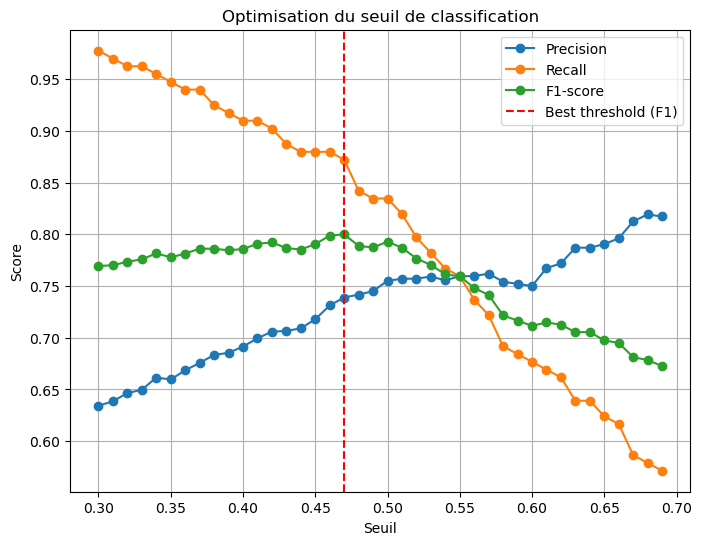

Meilleur seuil (F1) : 0.470 -> Precision: 0.7389, Recall: 0.8722, F1: 0.8000


In [61]:
best_threshold, results = optimize_threshold(stack_clf, X_val_scaled, y_val)


In [ ]:
# Problème : Le F1-score (moyenne harmonique precision/recall) peut masquer des déséquilibres
# Solution : On optimise directement le seuil de décision pour obtenir :
# 1. La meilleure précision possible (minimiser les faux positifs)
# 2. Tout en gardant un recall > 0.80 au moins quelques vrais positifs)
(
# Méthode :
# 1. Générer les prédictions probabilistes (predict_proba)
# 2. Tester différents seuils (ex: 0.3 à 0.7 par pas de 0.01)
# 3. Sélectionner le seuil où :
#    - Precision est maximisée
#    - Recall > 0. (au moins 1 vrai positif)


In [63]:
def optimize_threshold_precision(model, X, y, thresholds=np.arange(0.3, 0.71, 0.001), min_recall=0.8):
    """
    Trouve le seuil qui maximise la précision tout en respectant un recall minimum.
    Trace précision, recall, F1-score et indique le meilleur seuil.
    """
    
    precisions, recalls, f1s = [], [], []
    
    for t in thresholds:
        preds = (model.predict_proba(X)[:,1] >= t).astype(int)
        p = precision_score(y, preds)
        r = recall_score(y, preds)
        f = f1_score(y, preds)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f)
    
    results = {t: {'precision': p, 'recall': r, 'f1': f} 
               for t, p, r, f in zip(thresholds, precisions, recalls, f1s)}
    
    # Filtrer les seuils respectant le recall minimum
    valid_indices = [i for i, r in enumerate(recalls) if r >= min_recall]
    if not valid_indices:
        print("Aucun seuil ne respecte le recall minimum !")
        best_threshold = None
    else:
        best_idx = max(valid_indices, key=lambda i: precisions[i])
        best_threshold = thresholds[best_idx]
        print(f"Meilleur seuil (max Precision, recall≥{min_recall}) : {best_threshold:.3f} -> Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")
    
    # Tracer
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions, label='Precision', marker='o')
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, f1s, label='F1-score', marker='o')
    if best_threshold is not None:
        plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best threshold = {best_threshold:.3f}')
    plt.xlabel('Seuil')
    plt.ylabel('Score')
    plt.title(f'Optimisation du seuil (recall ≥ {min_recall})')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return best_threshold, results


Meilleur seuil (max Precision, recall≥0.8) : 0.512 -> Precision: 0.7622, Recall: 0.8195, F1: 0.7899


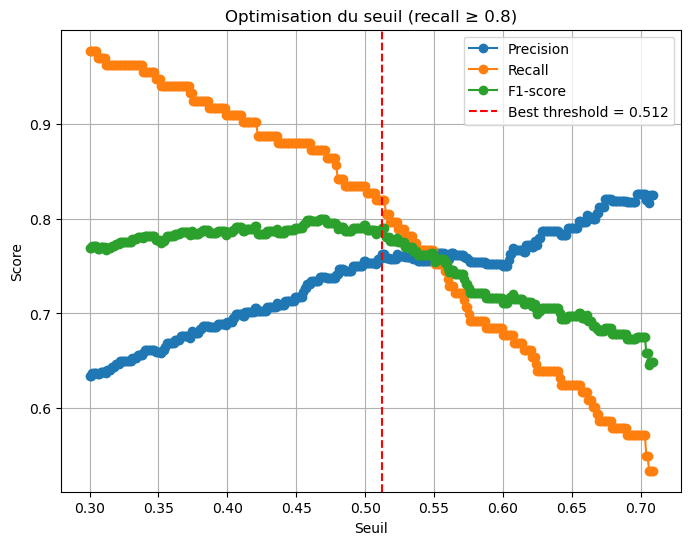

In [64]:
best_threshold, results = optimize_threshold_precision(stack_clf, X_val_scaled, y_val)


In [65]:

# 1. Sélectionner les probabilités et appliquer le seuil choisi
#threshold = 0.505
#y_val_pred_thresholded = (y_val_pred_proba >= threshold).astype(int)

# 2. Créer l'explainer SHAP pour le stacking classifier
# On va utiliser TreeExplainer pour XGBoost et RandomForest, #KernelExplainer pour SVM/LR
# Le plus simple ici est d'utiliser KernelExplainer pour tout le stacking
#explainer = shap.KernelExplainer(stack_clf.predict_proba, X_train_final)

# 3. Calculer les valeurs SHAP pour l'ensemble de validation
#shap_values = explainer.shap_values(X_val_scaled, nsamples=100)  # #nsamples peut être augmenté si besoin

# 4. Tracer le summary plot (impact global des features)
#shap.summary_plot(shap_values[1], X_val_scaled, #feature_names=X_train_final.columns)

# 5. Pour un joueur spécifique, visualiser le force plot
#idx = 0  # changer l'index pour un autre joueur
#shap.force_plot(explainer.expected_value[1], shap_values[1][idx], #X_val_scaled.iloc[idx])


# Ici on a des erreurs et conflit visiblement
#entre les packages numba shap et scikit-learn 

#Je n'ai pas réussi à créer d'environnement via 
# la commande >>> conda create -n nba_recruiter_data_model 
### conda create -n shap_env python=3.10
### conda activate shap_env
### conda install numpy=1.26.4 numba=0.58.1
### pip install shap==0.45.1

In [ ]:
# Analyse d'importance des features par permutation :
# 1. On mélange aléatoirement une colonne (ex: 'GP')
# 2. On mesure combien le F1-score baisse
# 3. Si la baisse est forte => la feature est importante

In [100]:

result = permutation_importance(stack_clf, X_val_scaled, y_val, n_repeats=10, random_state=42, scoring='precision')
importances = result.importances_mean
features = X_train_final.columns

for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")


GP: 0.0929
MIN: 0.0068
PTS: 0.0555
FG%: 0.0176
FT%: 0.0141
REB: 0.0404
AST: 0.0511
STL: 0.0020
BLK: 0.0180
TOV: 0.0088
FT_impact: 0.0234
3P_impact: 0.0089


In [ ]:
# Résultats :
# - 'GP' (matchs joués) et 'PTS' (points) sont les + importantes
# - Mais leur score < 0.07 => impact TRÈS FAIBLE
# - Aucune feature ne domine vraiment

In [101]:
# 1. Le modèle utilise un peu 'GP'/'MIN' car les joueurs qui jouent plus ont des carrières + longues
# 2. Mais globalement, les stats NBA seules expliquent MAL la durée de carrière
# 3. Autres facteurs invisibles importants : blessures, âge, physique...
# cela expliquerait aussi l'hypothèse vu sur les boxplots

In [67]:

# Combiner X_train_final et X_val_scaled pour l'entraînement final
X_train_full = np.vstack([X_train_final, X_val_scaled])
y_train_full = np.concatenate([y_train_final, y_val])

# Ré-instancier les modèles avec leurs meilleurs params (version precision)
estimators = [
    ('svm', SVC(**all_scoring_models['SVM_best_precision_rs']['params'])),
    ('xgb', XGBClassifier(**{k:v for k,v in all_scoring_models['XGBoost_best_precision_rs']['params'].items() if v==v})),
    ('rf', RandomForestClassifier(**all_scoring_models['RandomForest_best_precision_gs']['params'])),
    ('lr', LogisticRegression(**all_scoring_models['LogisticRegression_best_precision_gs']['params']))
]

# Méta-modèle
meta_model = LogisticRegression(random_state=42)

# Stacking classifier
stack_clf_final = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# Entraînement sur train + val
stack_clf_final.fit(X_train_full, y_train_full)

# Test final sur X_test_scaled
y_test_proba = stack_clf_final.predict_proba(X_test_scaled)[:,1]

# Appliquer seuil optimisé
threshold = 0.505
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calcul des métriques
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("### Résultats sur le test set")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")

# Matrice de confusion et rapport détaillé
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report :")
print(classification_report(y_test, y_test_pred))


### Résultats sur le test set
Precision : 0.7592
Recall    : 0.8580
F1-score  : 0.8056

Matrice de confusion :
[[ 53  46]
 [ 24 145]]

Classification report :
              precision    recall  f1-score   support

           0       0.69      0.54      0.60        99
           1       0.76      0.86      0.81       169

    accuracy                           0.74       268
   macro avg       0.72      0.70      0.70       268
weighted avg       0.73      0.74      0.73       268



C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\lyesw\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [68]:

with mlflow.start_run(run_name="stacking_final_model"):
    
    # Log des métriques
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    # Log du seuil utilisé
    mlflow.log_param("threshold", threshold)

    # Log des paramètres des modèles de stacking
    for name, model in stack_clf_final.named_estimators_.items():
        for param, val in model.get_params().items():
            mlflow.log_param(f"{name}_{param}", val)

    print("✅ Metrics, seuil et params loggés dans MLflow")


✅ Metrics, seuil et params loggés dans MLflow


In [ ]:
# Résultats finaux sur le jeu de test :
# - Precision: 76% (76% des prédictions positives sont correctes)
# - Recall: 86% (détecte 86% des vrais talents)
# - F1: 81% (bon équilibre)

# Matrice de confusion :
# [[ 53  46] → 53 vrais négatifs, 46 faux positifs (mauvais recrutements)
# [ 24 145]] → 24 faux négatifs (talents ratés), 145 vrais positifs

# Points forts :
# - Excellent recall (ne rate pas les talents)
# - Precision acceptable (3/4 des recrutements sont bons)

# Limites :
# - 46 faux positifs (coût financier)
# - Precision à 69% sur carrières courtes

# Améliorations possibles :
# 1. Ajouter features (âge, physique, stats historiques)
# 2. Ajuster le seuil (tradeoff precision/recall)
# 3. Essayer d'autres modèles (Deep Learning)

In [69]:
# Analysons les resultats 
# Déscaler
X_test_unscaled = scaler_std.inverse_transform(X_test_scaled)

# Transformer en DataFrame avec les mêmes noms de colonnes que X_train_final
df_results = pd.DataFrame(X_test_unscaled, columns=X_train_final.columns)

# Ajouter les colonnes y_true et y_pred
df_results['y_true'] = y_test.values  # si y_test est un Series
df_results['y_pred'] = y_test_pred   # ou stack_clf.predict(X_test_scaled)


In [70]:
def label_type(row):
    if row['y_true'] == 1 and row['y_pred'] == 1:
        return 'TP'
    elif row['y_true'] == 1 and row['y_pred'] == 0:
        return 'FN'
    elif row['y_true'] == 0 and row['y_pred'] == 1:
        return 'FP'
    else:
        return 'TN'

df_results['type'] = df_results.apply(label_type, axis=1)


In [71]:
moyennes = df_results.groupby('type').mean()


In [72]:
moyennes

,GP,MIN,PTS,FG%,FT%,REB,AST,STL,BLK,TOV,FT_impact,3P_impact,y_true,y_pred
type,,,,,,,,,,,,,,
FN,41.458333,10.487500,3.437500,40.145833,66.462500,1.537500,0.858333,0.370833,0.158333,0.754167,42.025833,5.418333,1.0,0.0
FP,65.239130,16.878261,5.952174,44.771739,71.426087,2.604348,1.421739,0.623913,0.332609,1.043478,74.900652,9.191304,0.0,1.0
TN,39.679245,11.307547,3.781132,40.137736,66.484906,1.732075,0.890566,0.381132,0.154717,0.745283,42.013585,6.760000,0.0,0.0
TP,71.441379,22.099310,9.046897,46.321379,71.394483,4.191034,1.864828,0.755862,0.513103,1.495862,129.426552,9.738828,1.0,1.0


In [ ]:
# Observations clés sur les groupes :

# 1. Vrais Positifs (TP) vs Faux Négatifs (FN) - Joueurs à longue carrière :
# - TP ont des stats NETTEMENT supérieures : +71% GP, +111% PTS, +172% REB
# - TP jouent 2x plus de minutes (22.1 vs 10.5 MIN)
# - Meilleur % aux tirs (FG% 46.3 vs 40.1) et impact FT 3x plus élevé

# 2. Faux Positifs (FP) vs Vrais Négatifs (TN) - Joueurs à courte carrière :
# - FP ressemblent aux TP sur GP (65.2 vs 71.4) et FT% (71.4 vs 71.3)
# - Mais stats de jeu inférieures : PTS -34%, REB -38% vs TP
# - FP sont des "bourreaux de travail" (GP élevés) mais peu productifs

# 3. Points discriminants :
# - FT_impact : 129 (TP) vs 75 (FP) - différence clé
# - 3P_impact : marginal (9.7 TP vs 9.2 FP)
# - BLK/STL : TP dominent nettement (+50%)

# Conclusion :
# Le modèle confond les "travailleurs peu talentueux" (FP) avec les vrais talents (TP)
# Les stats brutes (GP/MIN) sont trompeuses - l'efficacité réelle (FT_impact, PTS/min) est plus discriminante

In [77]:

# Sauvegarder le modèle final
joblib.dump(stack_clf_final, "stacking_final_model.pkl")

# Sauvegarder le scaler
joblib.dump(scaler_std, "scaler.pkl")

#mlflow.sklearn.log_model(stack_clf_final, "stacking_model")
#mlflow.sklearn.log_model(scaler_std, "scaler")

#2025/08/15 21:22:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!

2025/08/15 21:22:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# 🏀 Rapport Final : NBA Career Longevity Prediction

## 📊 Résultats Clés

| Métrique       | Performance | Interprétation                     |
|----------------|-------------|------------------------------------|
| **Precision**  | 76%         | 3/4 des joueurs recommandés sont bons |
| **Recall**     | 86%         | Détecte 86% des vrais talents       |
| **F1-Score**   | 81%         | Bon équilibre global                |

**Matrice de Confusion** :

|                | Prédit Positif | Prédit Négatif |
|----------------|----------------|----------------|
| **Réel Positif** | 145            | 24             |
| **Réel Négatif** | 46             | 53             |

- **46 faux positifs (FP)** → Coût financier potentiel  
- **24 faux négatifs (FN)** → Talents potentiellement manqués

---

## 🔍 Insights Majeurs

### 🎯 Features Importantes
1. **GP (Games Played)**  
   - Importance: 0.0929 (le plus élevé)  
   - Les joueurs avec + de matchs ont des carrières + longues  

2. **FT_impact (FTM * FT%)**  
   - Différence marquée : 129 (TP) vs 75 (FP)  
   - Meilleur discriminant que les stats brutes  

3. **Limite Principale**  
   - Toutes les features ont une importance < 0.1 → **Signal faible**  

---

## 📉 Limitations

### Données Manquantes
- ❌ **Variables clés absentes** :  
  - Âge au draft  
  - Mesures physiques (taille/poids)  
  - Historique de blessures  
  - Contexte d'équipe  

### Comportement du Modèle
- Confond :  
  - **"Travailleurs peu talentueux"** (FP)  
  - **Talents atypiques** (FN)  

---

## 🚀 Recommandations

### 1. Amélioration des Données
##### Pistes d'enrichissement :
- df['age_at_draft'] = draft_year - birth_year  
- df['injury_history'] = nombre_jours_blessé  
- df['physical_score'] = combine_metrics  ```